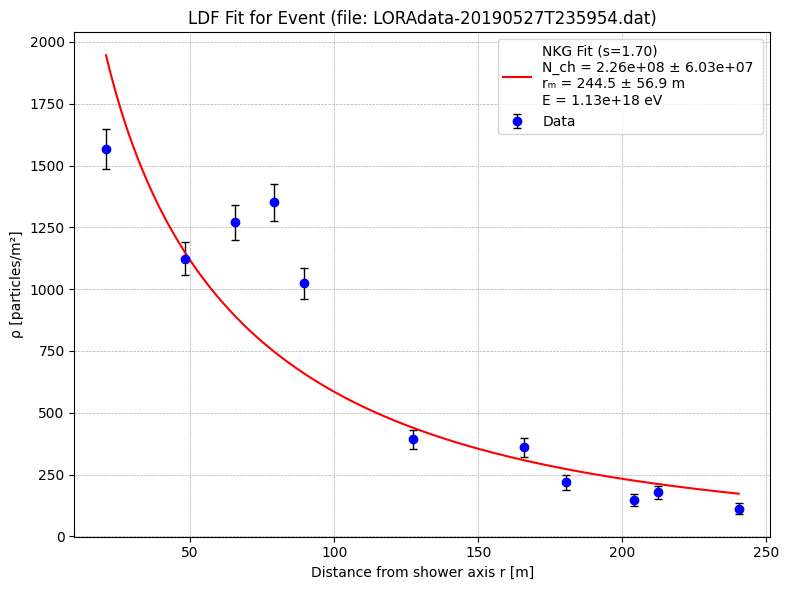

In [1]:
"""
Lateral Distribution Function (LDF) Fitting with Fixed NKG Age Parameter

This script performs fits of the Nishimura–Kamata–Greisen (NKG) lateral 
distribution function to LORA (LOFAR Radboud Air Shower Array) detector data, 
with the shower age parameter `s` fixed at 1.7. The Molière radius (r_m) is 
left unconstrained unless priors are provided.

Main Components:
----------------
1. **nkg_function_fixed_s(r, N_e, r_m, s=1.7)**
   - Implements the full, normalized NKG function with a fixed shower age `s`.
   - Parameters:
       r   : radial distances from the shower axis (meters)
       N_e : shower size (number of charged particles)
       r_m : Molière radius (meters)
       s   : fixed shower age parameter (default = 1.7)
   - Returns particle density at distance `r`.

2. **fit_nkg_with_priors(distances, densities, s, sigma_rho, ...)**
   - Fits the NKG function to measured LDF data using non-linear least squares.
   - Supports Gaussian priors for `N_e` and `r_m` if external estimates are 
     available (with associated uncertainties).
   - Returns best-fit values for `N_e` and `r_m` along with their uncertainties.

3. **extract_ldf_from_file(file_path)**
   - Parses a `.dat` file containing event information and detector measurements.
   - Extracts:
       - Core position (x, y)
       - Primary energy estimate
       - File-provided shower size (N_e) and Molière radius (r_m) with errors
       - Per-detector particle densities and distances from the core
   - Returns arrays of detector distances and densities plus metadata.

4. **min_distance_to_core(core_x, core_y, det_positions)**
   - Computes the minimum detector distance from the reconstructed shower core.
   - Used to flag potential bias if a detector is too close to the core.

Workflow:
---------
- Event data is read from a `.dat` file (default `file_path` provided).
- Detector distances from the shower axis and particle densities are extracted.
- The NKG function is fit to the data with fixed `s = 1.7`.
- If priors (`N_e`, `r_m`) are available in the file, they are used in the fit.
- Results are visualized:
    - Measured densities with error bars (2σ).
    - Best-fit NKG curve overlaid.
    - Fit parameters, primary energy (if available), and warnings for detectors 
      close to the core are shown in the legend.

Constants:
----------
NEAR_CORE_THRESHOLD = 10.0 m  # Distance below which a detector is flagged
FIXED_S = 1.7                 # Fixed shower age parameter

Example Usage:
--------------
Adjust the `file_path` to point to a `.dat` file, then run the script:

    $ python ldf_fit_fixeds.py

This will produce an LDF plot with the fit result and parameters.

Dependencies:
-------------
- numpy
- matplotlib
- scipy

"""
# Age parameter s is fixed = 1.7
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.special import gamma

# --- Constants ---
NEAR_CORE_THRESHOLD = 10.0  # meters
FIXED_S = 1.7               # fixed age parameter

# --- NKG Function with fixed s ---
def nkg_function_fixed_s(r, N_e, r_m, s=1.7):
    """
    Full standard NKG function with proper normalization.
    """
    # Normalization constant:
    C = 1 / (2 * np.pi * r_m**2) * gamma(4.5 - s) / (gamma(s) * gamma(4.5 - 2 * s))
    return N_e * C * (r / r_m)**(s - 2) * (1 + r / r_m)**(s - 4.5)

# --- Weighted fit with optional Gaussian priors ---
def fit_nkg_with_priors(distances, densities, s, sigma_rho,
                        Ne_prior=None, Ne_sigma=None,
                        rm_prior=None, rm_sigma=None,
                        p0=None):
    def residuals(params):
        Ne, rm = params
        model = nkg_function_fixed_s(distances, Ne, rm, s)
        res = (densities - model) / sigma_rho
        # add priors if provided
        if (Ne_prior is not None) and (Ne_sigma is not None) and Ne_sigma > 0:
            res = np.concatenate([res, [(Ne - Ne_prior) / Ne_sigma]])
        if (rm_prior is not None) and (rm_sigma is not None) and rm_sigma > 0:
            res = np.concatenate([res, [(rm - rm_prior) / rm_sigma]])
        return res

    if p0 is None:
        p0 = [1e5, 50.0]

    lsq = least_squares(residuals, p0, max_nfev=10000)

    # Approximate covariance from Jacobian (Gauss–Newton)
    J = lsq.jac
    dof = max(1, len(lsq.fun) - 2)
    chi2 = np.sum(lsq.fun**2)
    s2 = chi2 / dof
    try:
        pcov = np.linalg.inv(J.T @ J) * s2
        perr = np.sqrt(np.diag(pcov))
    except np.linalg.LinAlgError:
        perr = [np.nan, np.nan]

    Ne_fit, rm_fit = lsq.x
    Ne_err, rm_err = perr
    return Ne_fit, rm_fit, Ne_err, rm_err

# --- Extract data from file ---
def extract_ldf_from_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    core_x = core_y = energy = r_m_file = None
    Ne_file = NeErr_file = rM_err_file = None

    for line in lines:
        if not line.startswith("//") and line.strip():
            parts = line.strip().split()
            if len(parts) > 19:
                core_x = float(parts[2])
                core_y = float(parts[3])
                try:
                    energy = float(parts[6])
                except (ValueError, IndexError):
                    energy = None
                r_m_file = float(parts[9])          # Moliere radius (m)
                rM_err_file = float(parts[10])      # rM_error
                Ne_file = float(parts[14])          # Ne from file
                NeErr_file = float(parts[15])       # NeErr from file
            break

    if core_x is None or core_y is None:
        return np.array([]), np.array([]), None, None, None, None, None, None, None, None

    r = []
    rho = []
    det_positions = []

    for line in lines:
        if line.startswith("//") or not line.strip():
            continue
        parts = line.strip().split()
        if len(parts) < 16:
            continue
        try:
            det_x = float(parts[1])
            det_y = float(parts[2])
            density = float(parts[8])
            triggered = int(parts[15])
            if triggered == 0 or density <= 0:
                continue
            distance = np.sqrt((det_x - core_x)**2 + (det_y - core_y)**2)
            r.append(distance)
            rho.append(density)
            det_positions.append((det_x, det_y))
        except (ValueError, IndexError):
            continue

    return (np.array(r), np.array(rho),
            r_m_file, energy, core_x, core_y, det_positions,
            Ne_file, NeErr_file, rM_err_file)

# --- Minimum distance from core to detectors ---
def min_distance_to_core(core_x, core_y, det_positions):
    if not det_positions:
        return None
    distances = [np.sqrt((det_x - core_x)**2 + (det_y - core_y)**2) for det_x, det_y in det_positions]
    return min(distances)

# --- Main ---
file_path = "/home/wecapstor3/capn/mppi138h/LOFAR/scratch/stuti/lora-datapipeline/Output_all_root_events/LORAdata-20190527T235954.dat"  # <- CHANGE THIS TO YOUR FILE

(r, rho, r_m_file, energy, core_x, core_y, det_positions,
 Ne_file, NeErr_file, rM_err_file) = extract_ldf_from_file(file_path)

plt.figure(figsize=(8, 6))
if len(r) > 0:
    # 1σ for fit weighting
    sigma_rho_1sigma = np.sqrt(rho)
    sigma_rho_1sigma = np.where(sigma_rho_1sigma > 0, sigma_rho_1sigma, 1.0)
    # 2σ for plotting
    sigma_rho_2sigma = 2 * sigma_rho_1sigma

    plt.errorbar(r, rho, yerr=sigma_rho_2sigma, fmt='o', color='blue',
                 ecolor='black', elinewidth=1, capsize=3,
                 label='Data')

    # Initial guess: use file values if available
    p0 = [Ne_file if Ne_file is not None else 1e5,
          r_m_file if r_m_file is not None else 50.0]

    # Fit with priors from file
    Ne_fit, rm_fit, Ne_err, rm_err = fit_nkg_with_priors(
        r, rho, FIXED_S, sigma_rho_1sigma,
        Ne_prior=Ne_file, Ne_sigma=NeErr_file,
        rm_prior=r_m_file, rm_sigma=rM_err_file,
        p0=p0
    )

    fit_r = np.linspace(min(r), max(r), 200)
    fit_rho = nkg_function_fixed_s(fit_r, Ne_fit, rm_fit, s=FIXED_S)

    min_dist = min_distance_to_core(core_x, core_y, det_positions)
    near_core = (min_dist is not None and min_dist < NEAR_CORE_THRESHOLD)

    # Legend text
    label_lines = [
        f'NKG Fit (s={FIXED_S:.2f})',
        f'N_ch = {Ne_fit:.2e} ± {Ne_err:.2e} ',
        f'rₘ = {rm_fit:.1f} ± {rm_err:.1f} m '
    ]
    
    if energy is not None:
        label_lines.append(f'E = {energy:.2e} eV')
    if near_core:
        label_lines.append(f'Core near detector ({min_dist:.1f} m)')

    plt.plot(fit_r, fit_rho, color='red', label="\n".join(label_lines))
else:
    plt.scatter(r, rho, color='blue', label='Data')

plt.xlabel("Distance from shower axis r [m]")
plt.ylabel("ρ [particles/m²]")
plt.title(f"LDF Fit for Event (file: {file_path.split('/')[-1]})")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.tight_layout()
plt.show()


Total detectors in file: 20, Triggered: 12


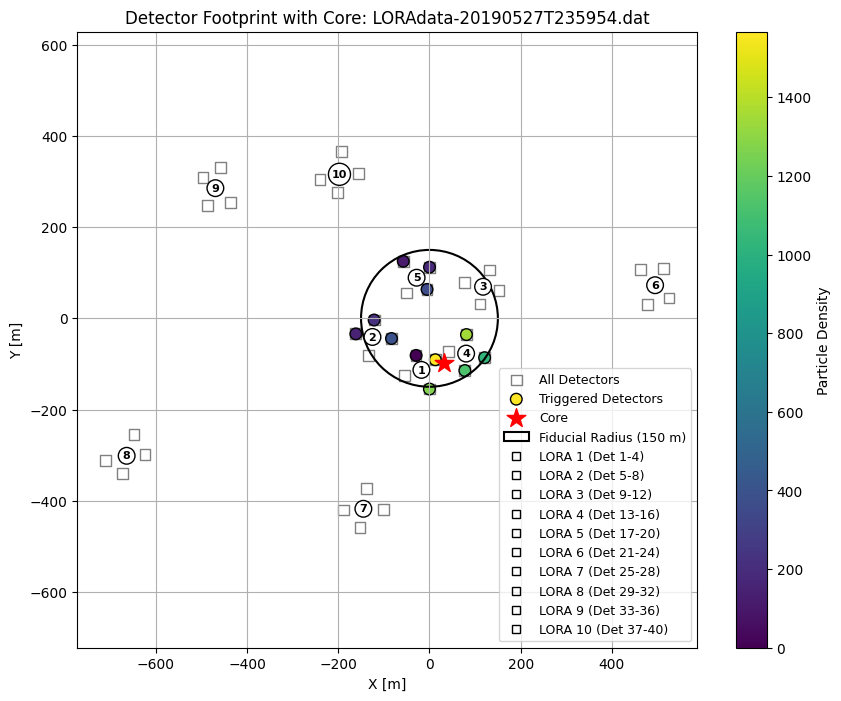

In [1]:
"""
Visualize detector footprint and triggered stations from a LORA .dat event file.

The script:
- Loads fixed detector coordinates and station groupings (LORA 1–10).
- Reads one .dat file containing event-level information:
    * core position (x, y),
    * per-detector properties (density, trigger flag, etc.).
- Selects triggered detectors and colors them by particle density.
- Plots:
    * All detectors (gray squares),
    * Triggered detectors (colored by density),
    * Shower core (red star),
    * Fiducial circle (150 m radius),
    * Station numbers and labels for clarity.

Output:
- 2D footprint plot showing which detectors fired
  and the reconstructed core position for the given event.
"""

import numpy as np
import matplotlib.pyplot as plt

# === Fixed LORA detector coordinates ===
detector_coords = np.array([
    [12.84, -90.78], [-29.28, -81.25], [-53.99, -125.12], [-0.10, -154.98],
    [-121.32, -3.68], [-83.25, -44.26], [-161.38, -34.07], [-133.88, -81.31],
    [76.14, 79.31], [152.35, 60.44], [110.83, 31.33], [130.88, 105.86],
    [77.63, -114.43], [120.95, -86.24], [41.87, -72.91], [81.13, -35.61],
    [-57.46, 125.07], [0.10, 112.14], [-5.30, 63.44], [-49.93, 55.55],
    [462.22, 106.33], [478.05, 30.78], [525.42, 44.37], [513.12, 109.06],
    [-188.11, -420.26], [-138.16, -372.49], [-101.12, -418.56], [-152.27, -459.11],
    [-647.88, -254.65], [-710.39, -312.13], [-673.64, -340.07], [-623.74, -298.66],
    [-458.37, 330.89], [-436.60, 253.78], [-485.96, 248.10], [-496.71, 308.90],
    [-192.97, 365.33], [-240.05, 304.57], [-155.08, 317.67], [-201.27, 275.63]
])

# === LORA station mapping ===
lora_station_labels = {
    "LORA 1": [0, 1, 2, 3],
    "LORA 2": [4, 5, 6, 7],
    "LORA 3": [8, 9, 10, 11],
    "LORA 4": [12, 13, 14, 15],
    "LORA 5": [16, 17, 18, 19],
    "LORA 6": [20, 21, 22, 23],
    "LORA 7": [24, 25, 26, 27],
    "LORA 8": [28, 29, 30, 31],
    "LORA 9": [32, 33, 34, 35],
    "LORA 10": [36, 37, 38, 39],
}

filename = "/home/wecapstor3/capn/mppi138h/LOFAR/scratch/stuti/lora-datapipeline/Output_all_root_events/LORAdata-20190527T235954.dat"

# === Read .dat file ===
with open(filename, 'r') as f:
    lines = f.readlines()

header = lines[1].strip().split()
core_x, core_y = float(header[2]), float(header[3])

detectors = []
for line in lines[4:]:
    parts = line.strip().split()
    if len(parts) < 15:
        continue
    det = {
        "id": int(parts[0]),
        "x": float(parts[1]),
        "y": float(parts[2]),
        "z": float(parts[3]),
        "utc": int(parts[4]),
        "nsecs": int(parts[5]),
        "adc": float(parts[6]),
        "gain": float(parts[7]),
        "density": float(parts[8]),
        "trigger": int(parts[-1])
    }
    detectors.append(det)

# Only keep triggered detectors
triggered = [d for d in detectors if d['trigger'] == 1]

print(f"Total detectors in file: {len(detectors)}, Triggered: {len(triggered)}")

# === Plot footprint ===
fig, ax = plt.subplots(figsize=(10, 8))

# All detectors
ax.scatter(detector_coords[:, 0], detector_coords[:, 1],
           facecolors='none', edgecolors='gray', marker='s', s=60, label='All Detectors')

# Triggered detectors colored by density
x = [d['x'] for d in triggered]
y = [d['y'] for d in triggered]
densities = [d['density'] for d in triggered]

sc = ax.scatter(x, y, c=densities, cmap='viridis', edgecolor='black', s=70, label='Triggered Detectors')
cbar = plt.colorbar(sc, ax=ax, label='Particle Density')

# Core
ax.scatter(core_x, core_y, c='red', marker='*', s=200, label='Core')

# Fiducial radius
fiducial_circle = plt.Circle((0, 0), 150, color='black', fill=False,
                             linestyle='-', linewidth=1.5, label='Fiducial Radius (150 m)')
ax.add_patch(fiducial_circle)

# === Add invisible handles for legend labels ===
for i, (station, indices) in enumerate(lora_station_labels.items(), start=1):
    first_det = indices[0] + 1
    last_det = indices[-1] + 1
    label = f"{station} (Det {first_det}-{last_det})"
    ax.plot([], [], 's', markerfacecolor='none', markeredgecolor='black', label=label)

# === Add visible station numbers to the plot ===
for i, (station, indices) in enumerate(lora_station_labels.items(), start=1):
    station_coords = detector_coords[indices]
    x_mean, y_mean = np.mean(station_coords[:, 0]), np.mean(station_coords[:, 1])
    ax.text(x_mean, y_mean, str(i), fontsize=8, fontweight='bold',
            ha='center', va='center', color='black',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='circle'))

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_title(f'Detector Footprint with Core: LORAdata-20190527T235954.dat')
ax.axis('equal')
ax.grid(True)
ax.legend(loc='lower right', fontsize=9, frameon=True)
plt.show()


📂 Plotting file: countsLORAdata-20170516T050841.h5


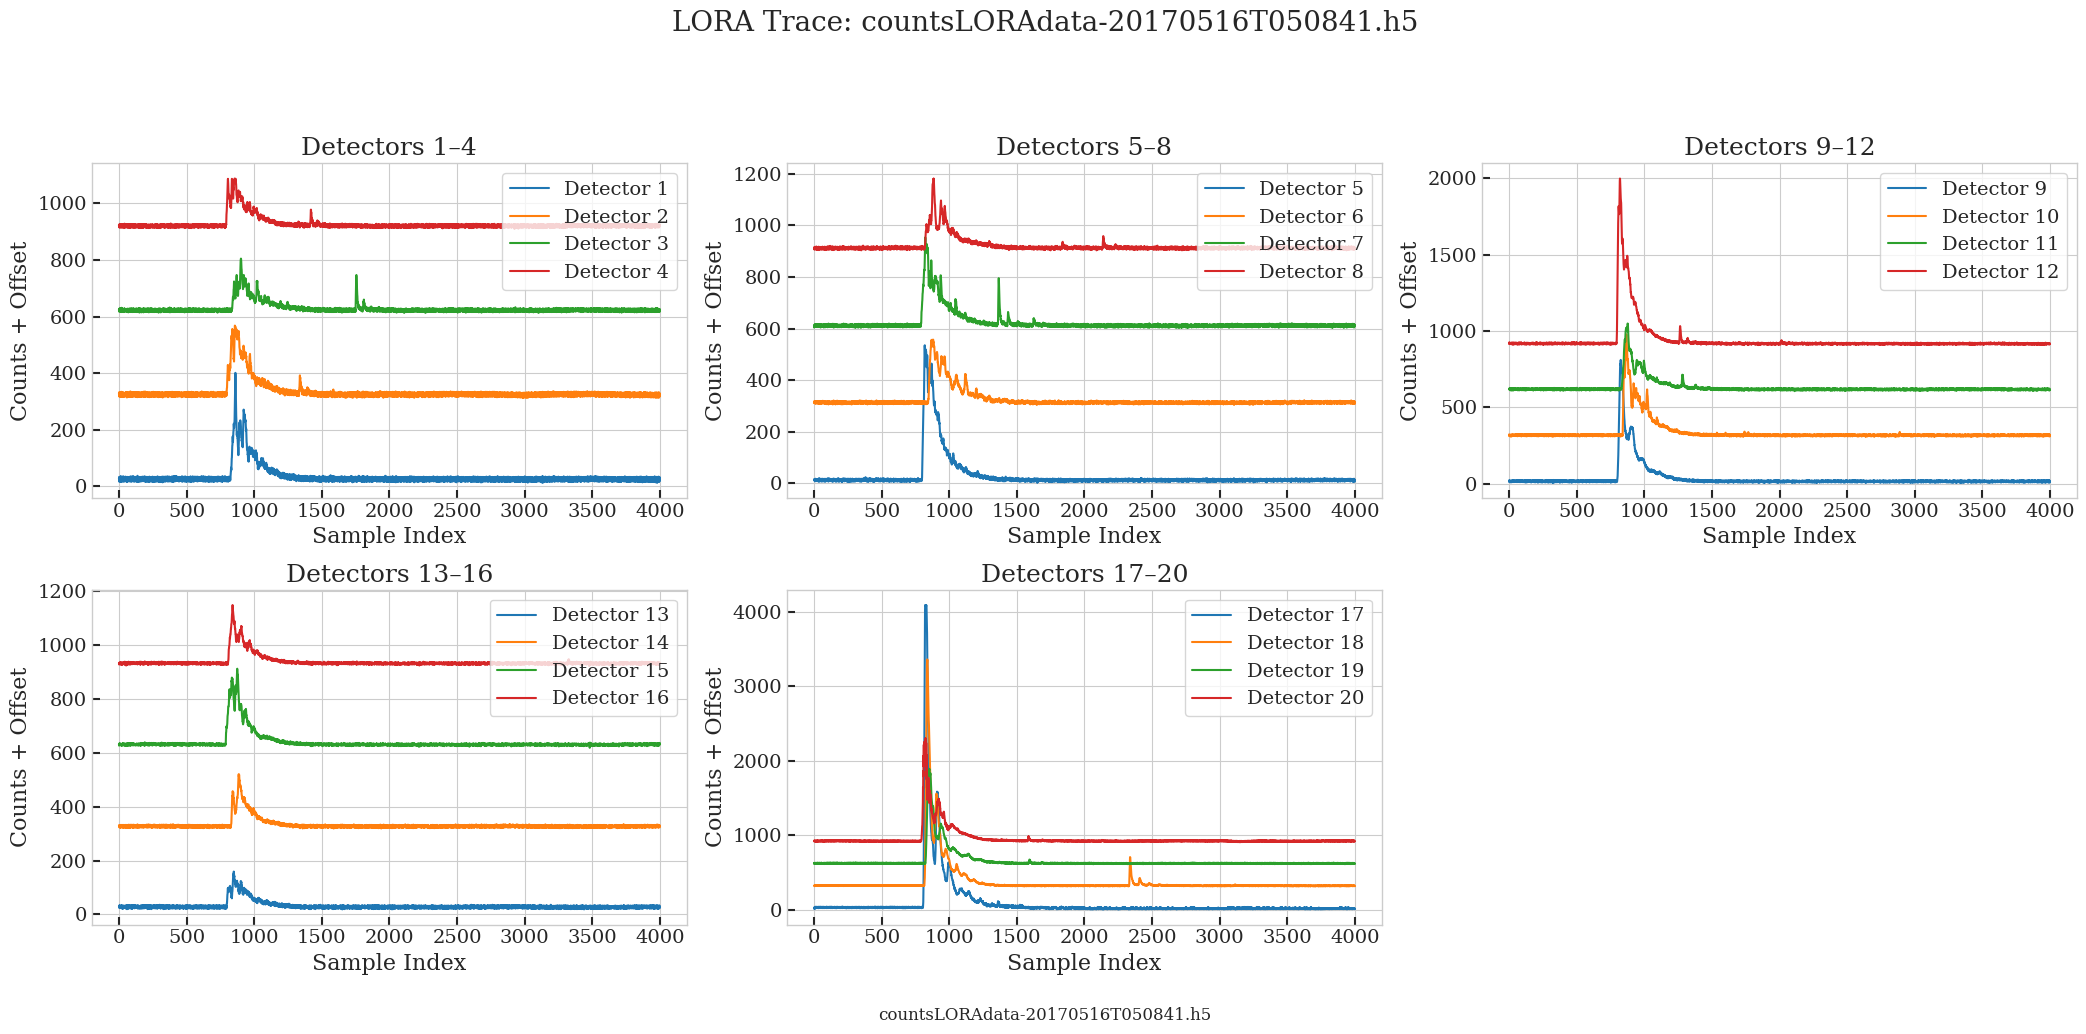

In [2]:
"""
LORA Detector Trace Visualization from HDF5 Files

This script reads pre-processed LORA detector count traces stored in HDF5 (.h5) 
files and generates multi-panel plots to visualize detector signals. It is 
useful for quickly inspecting raw detector responses for a given event.

Workflow:
---------
1. A `.dat` filename is provided (e.g., `LORAdata-YYYYMMDDTHHMMSS.dat`).
2. The script converts the timestamp to locate the corresponding `.h5` file 
   (named `countsLORAdata-<timestamp>.h5`).
3. The HDF5 file is opened and the dataset `counts` is read:
    - Shape: (N_samples, N_detectors)
    - Each column corresponds to a detector’s count trace.
4. Traces are plotted in grouped panels:
    - `detectors_per_plot` traces are shown in each subplot.
    - Vertical offsets (`offset_step`) are applied for clarity.
    - Each subplot is titled with the detector range it covers.
5. The figure is formatted with scientific plotting styles and annotations.

Plotting Settings:
------------------
- detectors_per_plot : int
    Number of detectors shown in each subplot.
- offset_step : int
    Vertical offset applied to separate traces visually.
- Global matplotlib style settings are applied for a clean, publication-ready look.

Error Handling:
---------------
- `FileNotFoundError`: Raised if the expected `.h5` file is missing.
- `KeyError`: Raised if the dataset `'counts'` is not found in the HDF5 file.

Example Usage:
--------------
Place the corresponding `.h5` files in the directory specified by `base_path`, 
then run the script. For example:

    dat_files = ["LORAdata-20170516T050841.dat"]

    $ python plot_lora_traces.py

This will generate subplots with detector traces offset and grouped by detector 
number.

Dependencies:
-------------
- h5py
- numpy
- matplotlib
- os

"""

import h5py
import numpy as np
import matplotlib.pyplot as plt
import os

# Use a clean, scientific style
plt.style.use('seaborn-v0_8-whitegrid')

# Example file
dat_files = [
    "LORAdata-20170516T050841.dat"
]

# Path to .h5 files
base_path = '/home/wecapstor3/capn/mppi138h/LOFAR/scratch/stuti/lora-datapipeline/Output_all_root_events'

# Plotting settings
detectors_per_plot = 4
offset_step = 300  # vertical offset between detectors

# Global style settings
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'serif',
    'lines.linewidth': 1.5
})

for dat_file in dat_files:
    timestamp = dat_file.split("LORAdata-")[1].replace(".dat", "")
    h5_filename = f"countsLORAdata-{timestamp}.h5"
    h5_filepath = os.path.join(base_path, h5_filename)

    print(f"📂 Plotting file: {h5_filename}")

    try:
        with h5py.File(h5_filepath, 'r') as f:
            counts = f['counts'][:]

        num_detectors = counts.shape[1]
        num_plots = int(np.ceil(num_detectors / detectors_per_plot))

        # Make 2 rows
        num_cols = int(np.ceil(num_plots / 2))
        num_rows = 2

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(7 * num_cols, 5 * num_rows), squeeze=False)
        axs = axs.flatten()
        x_axis = np.arange(counts.shape[0])

        for i in range(num_plots):
            ax = axs[i]
            start_idx = i * detectors_per_plot
            end_idx = min(start_idx + detectors_per_plot, num_detectors)

            for j in range(start_idx, end_idx):
                offset = (j - start_idx) * offset_step
                ax.plot(x_axis, counts[:, j] + offset, label=f'Detector {j + 1}')

            ax.set_title(f'Detectors {start_idx + 1}–{end_idx}')
            ax.set_xlabel('Sample Index')
            ax.set_ylabel('Counts + Offset')
            ax.legend(loc='best', frameon=True)
            ax.tick_params(direction='in', length=6, width=1.5)

        # Hide any unused subplots if num_plots < num_rows * num_cols
        for i in range(num_plots, num_rows * num_cols):
            fig.delaxes(axs[i])

        fig.suptitle(f'LORA Trace: {h5_filename}', fontsize=20, y=1.02)
        plt.figtext(0.5, 0.01, h5_filename, wrap=True, ha='center', fontsize=12)
        plt.tight_layout(rect=[0, 0.04, 1, 0.95])
        plt.show()

    except FileNotFoundError:
        print(f"File not found: {h5_filepath}")
    except KeyError:
        print(f"Dataset 'counts' not found in file: {h5_filepath}")
